## Analysing relevant documents for better optimization

1. load relevant document id's from qrels file
2. get information from relevant documents
3. visualize results

In [151]:
import csv
from pprint import pprint
from elasticsearch import Elasticsearch
from credentials import username, password

### Gather relevant ids

In [188]:
qrels_path = "data/qrels-covid_d5_j0.5-5_covid-complete.txt"

with open(qrels_path) as csvfile:
    qrels_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    
    # itter over rows cord_uid is in col 2
    relevant_ids = []
    irrelevant_ids = []
    for q_id, _, cord_uid, relevance in qrels_reader:
        if int(relevance) > 0:
            relevant_ids.append(cord_uid)
        else:
            irrelevant_ids.append(cord_uid)
    
    print("Relevant ids:", len(relevant_ids))
    print("Irrelevant ids:", len(irrelevant_ids))

    # transform to set to kick out doubles
    relevant_ids_unique = set(relevant_ids)
    irrelevant_ids_unique = set(irrelevant_ids)
    print("Relevant ids unique:", len(relevant_ids_unique))
    print("Irrelevant ids unique:", len(irrelevant_ids_unique))

Relevant ids: 26664
Irrelevant ids: 42654
Relevant ids unique: 19240
Irrelevant ids unique: 25833


We now have a set of relevant documents in the form of id's. We now have to search for those id's in our elasticsearch index to gather information on them.  
To search for our ids we will need to initiate a connection to elasticsearch first.

In [189]:
es = Elasticsearch(
    "http://localhost:9200",
    basic_auth=(username, password)
)

Before making our search we will have to formulate a search query. We will use the search the index with the [terms](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-terms-query.html) function. We transformed our list of document ids to a set before now we will need to transform it back into a list because elasticsearch does not know the datatype set.

In [190]:
query = {
    "query": {
        "terms": {
            "cord_uid": list(relevant_ids_unique)
        }
    },
    "size": 10000,
    "sort": [
        {"cord_uid": "asc"}
    ]
}

Because we need to retrieve 37924 documents we will need to make multiple queries. We use a sort which will give us the exact same result set every time and make it possible to shift our window of how many documents we want to see. When provided with a sort Elasticsearch gives back the value of the sort with each query. We can then enter this value on the next query so that elasticsearch provides the next 10000 matches after that value.

In [191]:
documents_rel = []

# split number of documents into slices of 10000
for splits in range(len(relevant_ids_unique) // 10000 + 1):
    if splits == 0:
        results = es.search(body=query, index="test_index")    
    
    else:
        # set search after parameter to page through large amount of results
        query["search_after"] = [search_after]

        results = es.search(body=query, index="test_index")  

    documents_in_split = results["hits"]["hits"]

    # combine all splits into one list
    documents_rel.extend(documents_in_split)

    # get the sort id to use search_after feature
    last_document = documents_in_split[-1]
    search_after = last_document["sort"][0]

/tmp/ipykernel_8275/4040693353.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(body=query, index="test_index")
/tmp/ipykernel_8275/4040693353.py:12: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(body=query, index="test_index")


In [192]:
len(documents_rel)

19240

As we can see from the lengt of documents provided our query probably worked and we retrieve exactly all the relevant documents we wanted. But just to make sure lets test if that really is the case.

Lets create a new set with all the cord_uids from the retrieved documents and see if this set matches our old set

In [194]:
relevant_ids_retrieved = set([doc["_source"]["cord_uid"] for doc in documents_rel])
relevant_ids_retrieved == relevant_ids_unique

True

As we can see they both match which means we can now start analysing these documents to find relevant information to use in our optimization.

### Get irrelevant documents for later analysis of Kbest

In [195]:
query = {
    "query": {
        "terms": {
            "cord_uid": list(irrelevant_ids_unique)
        }
    },
    "size": 10000,
    "sort": [
        {"cord_uid": "asc"}
    ]
}

In [196]:
documents_ir = []

# split number of documents into slices of 10000
for splits in range(len(irrelevant_ids_unique) // 10000 + 1):
    if splits == 0:
        results = es.search(body=query, index="test_index")    
    
    else:
        # set search after parameter to page through large amount of results
        query["search_after"] = [search_after]

        results = es.search(body=query, index="test_index")  

    documents_in_split = results["hits"]["hits"]

    # combine all splits into one list
    documents_ir.extend(documents_in_split)

    # get the sort id to use search_after feature
    last_document = documents_in_split[-1]
    search_after = last_document["sort"][0]

/tmp/ipykernel_8275/1118810009.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(body=query, index="test_index")
/tmp/ipykernel_8275/1118810009.py:12: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  results = es.search(body=query, index="test_index")


In [198]:
irrelevant_ids_retrieved = set([doc["_source"]["cord_uid"] for doc in documents_ir])
irrelevant_ids_retrieved == irrelevant_ids_unique

True

## Document analysis

In [385]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from collections import Counter

### Time analysis

Our first point of analysis will be when the documents where published. To do that we will extract all dates from our documents and make a timeline plot. Because we want to do this for all our relevant and irrelevant documents we will have to do all steps twice

In [200]:
dates = []
for docs in [documents_rel, documents_ir]:
    dates.append([doc["_source"]["publish_time"] for doc in docs])

In [362]:

all_dates_casted = []
all_dates_casted_month = []

for documents in dates:
    date_casted = []
    date_casted_month = []
    for date in documents:
        

        
        # skip all values that are none
        if not date:
            continue

        # first try casting a complete string if that does not work only cast the year
        try:
            date_cast = datetime.strptime(date, "%Y-%m-%d")
            date_casted_month.append(date_cast)
        except ValueError:
            date_cast = datetime.strptime(date, "%Y")

        date_casted.append(date_cast)
    all_dates_casted_month.append(date_casted_month)
    all_dates_casted.append(date_casted)

dates_rel, dates_ir = all_dates_casted
dates_rel_mon, dates_ir_mon = all_dates_casted_month


In [363]:

# create a list with only the years
years_rel = [date.year for date in dates_rel]
years_ir = [date.year for date in dates_ir]

# Count the years
years_counted_rel = Counter(years_rel)
years_counted_ir = Counter(years_ir)

# split keys and values from dictionary into list x, y
x_rel, y_rel = zip(*years_counted_rel.items())
x_ir, y_ir = zip(*years_counted_ir.items())

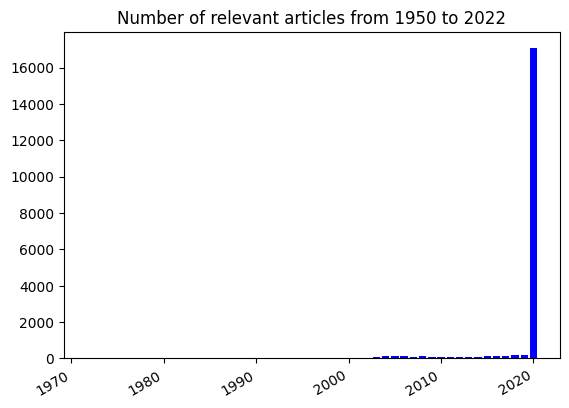

In [364]:
plt.bar(x_rel, y_rel, color="blue")
plt.gcf().autofmt_xdate()
plt.title("Number of relevant articles from 1950 to 2022")
plt.show()

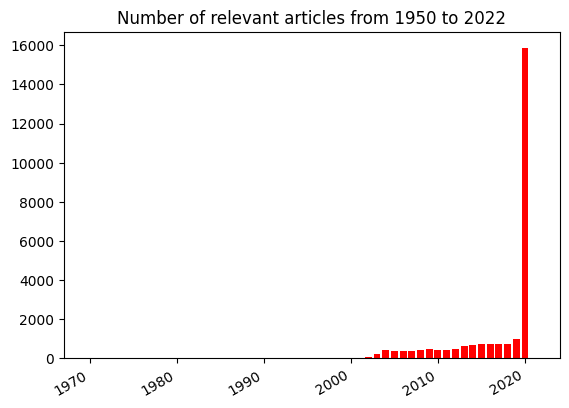

In [365]:
plt.bar(x_ir, y_ir, color="red")
plt.gcf().autofmt_xdate()
plt.title("Number of relevant articles from 1950 to 2022")
plt.show()

We can now visualize how many relevant articles there have been over the years. As we can see the documents only start beeing relevant roughly after the year 2000. So lets zoom in on that.

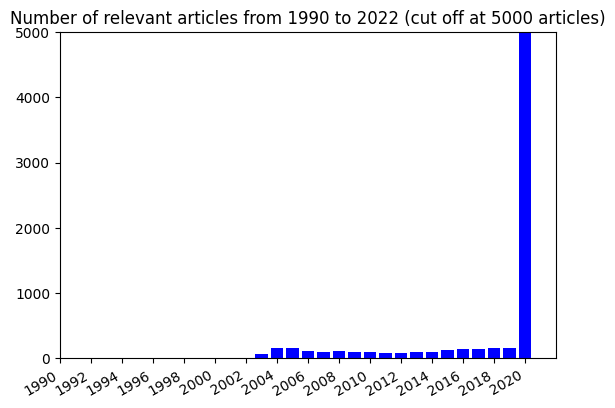

In [366]:

plt.bar(x_rel, y_rel, color="blue")
plt.xlim(1990, 2022)
plt.ylim(0, 5000)
plt.xticks(range(1990, 2022, 2))
plt.gcf().autofmt_xdate()
plt.title("Number of relevant articles from 1990 to 2022 (cut off at 5000 articles)")
plt.show()

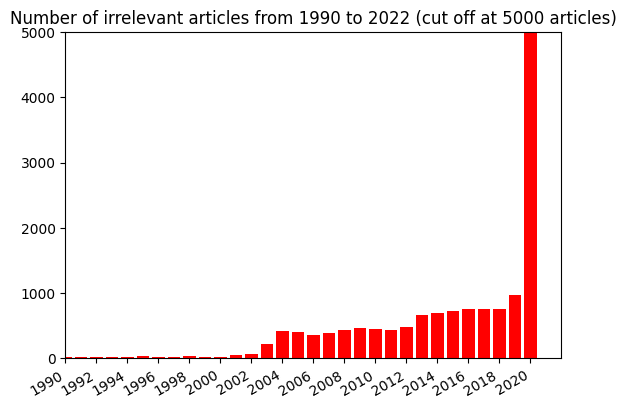

In [367]:

plt.bar(x_ir, y_ir, color="red")
plt.xlim(1990, 2022)
plt.ylim(0, 5000)
plt.xticks(range(1990, 2022, 2))
plt.gcf().autofmt_xdate()
plt.title("Number of irrelevant articles from 1990 to 2022 (cut off at 5000 articles)")
plt.show()

In [428]:
# remove day from dates
dates_rel_ym = [date(date_obj.year, date_obj.month, 1) for date_obj in dates_rel_mon]
dates_ir_ym = [date(date_obj.year, date_obj.month, 1) for date_obj in dates_ir_mon]

# Count the years
years_counted_rel = Counter(dates_rel_ym)
years_counted_ir = Counter(dates_ir_ym)

# split keys and values from dictionary into list x, y
x_rel, y_rel = zip(*years_counted_rel.items())
x_ir, y_ir = zip(*years_counted_ir.items())


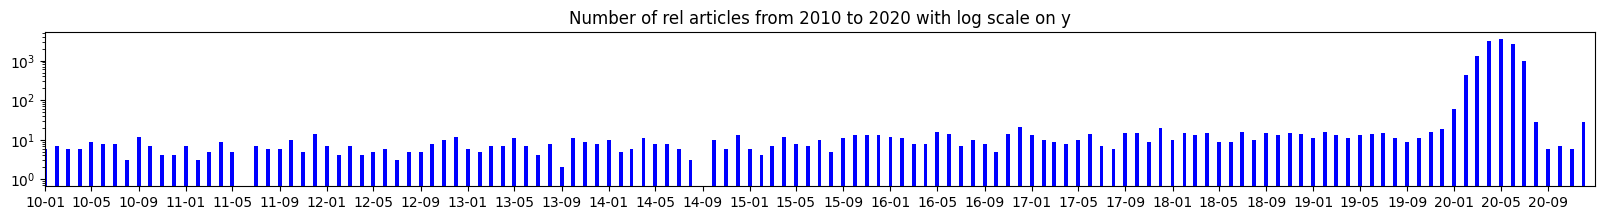

In [429]:

plt.figure(figsize=(20, 2))
plt.bar(x_rel, y_rel, color="blue", width=10)
# plt.xlim()
# plt.xticks(range(1990, 2022, 10))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.yscale("log")
left = date(2010, 1, 1)
right = date(2020, 12, 31)
plt.gca().set_xbound(left, right)


plt.title("Number of rel articles from 2010 to 2020 with log scale on y")
plt.show()

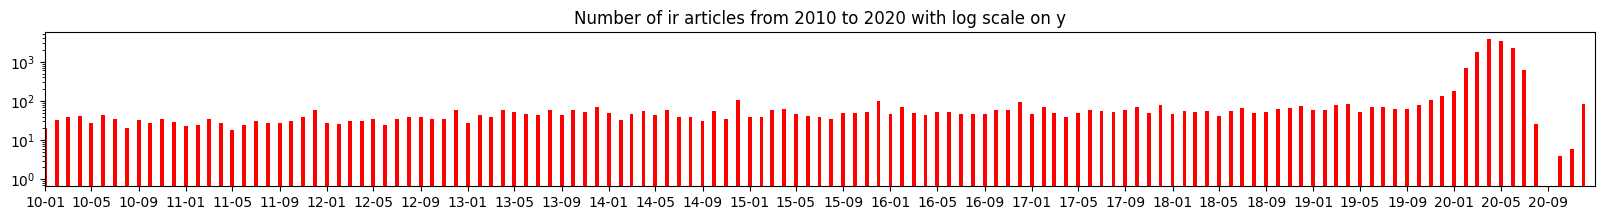

In [470]:

plt.figure(figsize=(20, 2))
plt.bar(x_ir, y_ir, color="red", width=10)
# plt.xlim()
# plt.xticks(range(1990, 2022, 10))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.yscale("log")
left = date(2010, 1, 1)
right = date(2020, 12, 31)
plt.gca().set_xbound(left, right)


plt.title("Number of ir articles from 2010 to 2020 with log scale on y")
plt.show()

#### Conclusion
As we can see the amount of relevant and irrelevant documents is the same for 2020. But after that there are a lot more irrelevant documents then relevant documents.
We can pretty confidently make a very steep function_score function where we punish all articles older then 2020 until. 2004 should be the most punishment.

#### Modelling a decay function

In [432]:
import numpy as np

In [471]:
origin = 14
scale = 20 # 20 months
offset = 0
decay = 0.5

def exp(date, origin, scale, offset, decay):
    y = np.log(decay)/scale
    return np.exp(y * np.max([0, np.abs(date - origin) - offset]))

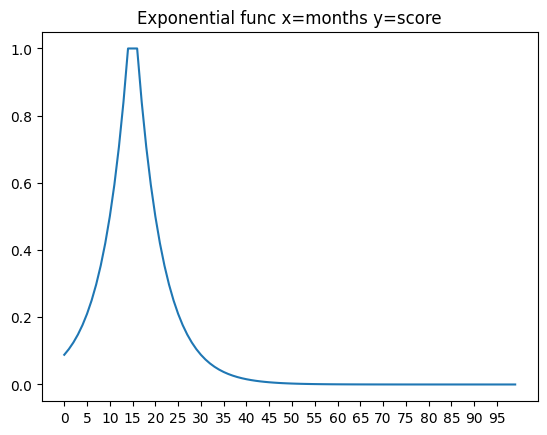

In [482]:
x = np.arange(0, 100, 1)
y = [exp(date=x_val, origin=15, scale=4, offset=1, decay=0.5) for x_val in x]

plt.plot(x, y)
plt.xticks(np.arange(0, 100, 5))
plt.title("Exponential func x=months y=score")
plt.show()

## Dataset analysis

### Dataset creation (you can skip this part not too interesting)

We want to create a dataset with relevant and irrelevant documents and train an algorithm to find out what columns indicate wheater or not a document is relevant or not

First we will create our dataset. We want the dataset balanced which is why we take the same amount of relevant and irrelevant docuements.

In [224]:
import random

To create our dataset we have to take our documents and only use columns that actually carry information.

In [237]:
all_documents = [documents_ir, documents_rel]

# specify what columns to use
columns = ['cord_uid', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 
'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'url']

all_documents_reduced = []

for relevance_score, documents in enumerate(all_documents):
    documents_reduced = []

    for doc in documents:
        source = doc["_source"]
        doc_cols = [source[col] for col in columns]
        
        # write special column relevance score
        doc_cols.append(relevance_score)
        documents_reduced.append(doc_cols)

    all_documents_reduced.append(documents_reduced)

# add relevance score to column names
columns.append("relevance_score")

In [238]:
# combine all documents for one export
documents_export_ready = all_documents_reduced[0] + all_documents_reduced[1]
len(documents_export_ready)

In [240]:
# create a csv writer
csv_writer = csv.writer(open("data/relevance_dataset.csv", "w"))
# write column names first
csv_writer.writerow(columns)
csv_writer.writerows(documents_export_ready)

### Missing column value analysis
The thought is: Columns with a missing abstract can't really be all that relevant can they? Or columns that do not have a doi probably don't have one because they aren't that good. Let's test this hypothesis

In [241]:
import pandas as pd

In [247]:
df = pd.read_csv("data/relevance_dataset.csv")

/tmp/ipykernel_8275/473339600.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/relevance_dataset.csv")


In [250]:
df_rel = df.loc[df["relevance_score"] == 1].copy()
df_ir = df.loc[df["relevance_score"] == 0].copy()

In [301]:
# percentage of na values per column
per_missing_rel = round(df_rel.isna().sum() / len(df_rel) * 100)
per_missing_ir = round(df_ir.isna().sum() / len(df_ir) * 100)

index = list(per_missing_ir.index)

print("Percent of documents fields missing for")
pd.DataFrame(data={"Irrelevant": per_missing_ir, "Relevant": per_missing_rel})

Percent of documents fields missing for


,Irrelevant,Relevant
cord_uid,0.0,0.0
source_x,0.0,0.0
title,0.0,0.0
doi,16.0,29.0
pmcid,35.0,53.0
pubmed_id,36.0,49.0
license,0.0,0.0
abstract,15.0,15.0
publish_time,0.0,0.0
authors,2.0,1.0


Alright not really saying anything might be ablet to use some of this information but i doubt it.

### Abstract analysis

In [322]:
# average text length
avg_len_rel = df_rel["abstract"].str.len().sum() / len(df_rel)
avg_len_ir = df_ir["abstract"].str.len().sum() / len(df_ir)
pd.DataFrame(data={"Irrelevant": avg_len_ir, "Relevant": avg_len_rel}, index=["avg abstract len"])

,Irrelevant,Relevant
avg abstract len,1210.943367,1205.383492
